## POS tagging using modified Viterbi

# Problem Statement:
Modify vanilla viterbi algorithm to increase the accuracy of finding POS tags.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pprint, time
import pdb

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

##### Understanding the tagged data

In [3]:
# 1. Let's look at the representation of each sentence in the data set
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

###### Above we can see it is a list of list of tuples i.e. lists of all sentences in a list with word, pos tags in tuples inside each list

In [4]:
# 2. Convert the list of sentences into a list of word,pos_tags tuples
nltk_data_tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(nltk_data_tagged_words))

100676


###### Hence, there are 100676 word, pos-tag tuples

### Exploratory Data Analysis

In [5]:
# 1. How many unique tags exists in Universal tag set
tags = [pair[1] for pair in nltk_data_tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

###### Hence, there are 12 unique tags

In [6]:
# Let's see the list of tags
unique_tags

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [7]:
# 2. Frequency of tags in the data set and most frequent tag
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'.': 11715,
         'ADJ': 6397,
         'ADP': 9857,
         'ADV': 3171,
         'CONJ': 2265,
         'DET': 8725,
         'NOUN': 28867,
         'NUM': 3546,
         'PRON': 2737,
         'PRT': 3219,
         'VERB': 13564,
         'X': 6613})

In [8]:
# Most common tag
tag_counts.most_common(5)

[('NOUN', 28867), ('VERB', 13564), ('.', 11715), ('ADP', 9857), ('DET', 8725)]

##### Hence, most common tag is noun followed by verb, ., adpositions(prepositions and postpositions), Determiners

### Build the vanilla Viterbi based POS tagger

In [9]:
# 1. Split the dataset into train and test data - 95% - 5% of sentences
np.random.seed(1234)
nltk_data_train_set, nltk_data_vali_set = train_test_split(nltk_data,test_size=0.05)
print(len(nltk_data_train_set))
print(len(nltk_data_vali_set))
print(nltk_data_train_set[:5])

3718
196
[[('This', 'DET'), ('year', 'NOUN'), (',', '.'), ('the', 'DET'), ('average', 'NOUN'), ('of', 'ADP'), ('daily', 'ADJ'), ('contracts', 'NOUN'), ('traded', 'VERB'), ('*', 'X'), ('totaled', 'VERB'), ('9,118', 'NUM'), (',', '.'), ('up', 'ADP'), ('from', 'ADP'), ('4,645', 'NUM'), ('a', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), ('and', 'CONJ'), ('from', 'ADP'), ('917', 'NUM'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.')], [('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('now', 'ADV'), ('has', 'VERB'), ('45', 'NUM'), ('banks', 'NOUN'), ('and', 'CONJ'), ('$', '.'), ('12.5', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('assets', 'NOUN'), (',', '.'), ('announced', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('the', 'DET'), ('Peoria', 'NOUN'), (',', '.'), ('Ill.', 'NOUN'), (',', '.'), ('bank', 'NOUN'), ('holding', 'VERB'), ('company', 'NOUN'), ('in', 'ADP'), ('January',

In [10]:
# 2. create List of tagged words for test and train dataset
train_tagged_words = [tup for sent in nltk_data_train_set for tup in sent]
print(len(train_tagged_words))

95799


In [11]:
validation_tagged_words = [tup for sent in nltk_data_vali_set for tup in sent]
print(len(validation_tagged_words))

4877


In [12]:
# We could have divided the words in the 95 is to 5 ratio but its better to take dataset as sentences as there may occur sentences
# with more number of words compared to others. 
# As we see 4877 is around 4.84% of total words which is almost near to 5% so, if we would have splitted it after converting list of sentence
# to list of word,pos then also that would not have made much difference.

##### Note (Important): Our aim is to start with vanilla viterbi algorithm and then improve the algorithm to find correct pos-tags for unknown words
For doing so we need to look at one important observation. The observation is that the validation data set should have words (unknown) which 
are not present in training data set in order to evaluate that whether the models are improving or not on unknown words and hence, overall

In [13]:
# 3. Check if validation data set has unknown words
words_train_set = [pair[0] for pair in train_tagged_words]
# Vocablary of training dataset
vocab_train_set = set(words_train_set)
print(len(vocab_train_set))

12073


In [14]:
words_validation_set = [pair[0] for pair in validation_tagged_words]
# vocablary of validation dataset
vocab_validation_set = set(words_validation_set)
print(len(vocab_validation_set))

1877


In [15]:
# Get a list of words in validation data set which are not present in training data set

In [16]:
unknown_words = np.setdiff1d(words_validation_set,words_train_set)
print(len(unknown_words))

335


In [17]:
unknown_words

array(['*-129', '*-139', '*-158', '*T*-104', '*T*-110', '*T*-120',
       '*T*-121', '*T*-151', '*T*-152', '*T*-153', '*T*-194', '*T*-223',
       '*T*-230', '*T*-232', '*T*-234', '*T*-260', '0.56', '0.84', '1.24',
       '1.39', '11.5', '12-member', '130.7', '14.43', '14.53', '154.2',
       '1637', '1917', '1933', '1934', '1961', '1968', '1988-89', '1997',
       '3.16', '3.28', '300-113', '300-day', '341.20', '387.8', '422.5',
       '446.62', '45.2', '490', '5.57', '5.63', '500-Stock', '6.44',
       '62.1', '620', '8.35', '8.60', '8.9', '84.9', '913', 'AC-130U',
       'Abbey', 'Activity', 'Agnew', 'Always', 'Ancient', 'Anglian',
       'Arabian', 'Asians', 'Back', 'Bears', 'Brenda', 'Bucking', 'Bugs',
       'Bunny', 'Carbide', 'Card', 'Cathedral', 'Characters', 'Charlie',
       'Clemens', 'Communists', 'Concurrent', 'Cullowhee', 'DEFENSE',
       'Dakotas', 'Debt', 'Default', 'Different', 'Dogs', 'Dolan',
       'Dolphin', 'Elisabeth', 'GOODY', 'Gingl', 'Glauber', 'Goode',
    

In [18]:
# 4. Recheck the number of tags in train data set so that we are sure about all the tags availabilty in training dataset 
# This will help in creating a good model as all type of data will be avaliable
tags_train = [pair[1] for pair in train_tagged_words]
unique_tags = set(tags_train)
T = len(unique_tags)
print(T)

12


##### Yes, there are quite a lot unknown words in validation set and all the 12 tags are available in training dataset

In [19]:
# We are ready to run the Vanilla Viterbi algorithm for assigning pos-tags
# 5. Emission probabilities calculation - computing P(w/t) and storing in T x V matrix
t = len(unique_tags)
v = len(vocab_train_set)
w_given_t = np.zeros((t, v))

In [20]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [21]:
# 6. Transition probabilities - ompute tag given tag: tag2(t2) given tag1 (t1)
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [22]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(unique_tags), len(unique_tags)), dtype='float32')
for i, t1 in enumerate(list(unique_tags)):
    for j, t2 in enumerate(list(unique_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [23]:
tags_matrix

array([[9.40700844e-02, 2.33602873e-03, 4.46540862e-02, 5.77717870e-02,
        8.87690932e-02, 8.05929899e-02, 1.73225522e-01, 9.03863460e-02,
        2.23090753e-01, 6.57681972e-02, 2.73135677e-02, 5.19317165e-02],
       [4.16938104e-02, 1.95439742e-03, 8.40390846e-02, 2.28013028e-03,
        4.02931601e-01, 5.66775240e-02, 9.96742696e-02, 2.11726390e-02,
        2.47882739e-01, 1.79153103e-02, 1.40065150e-02, 9.77198686e-03],
       [6.58090040e-02, 1.08857006e-02, 6.53142035e-02, 1.66584197e-02,
        1.22051788e-02, 2.11116616e-02, 4.94804559e-03, 7.75193796e-02,
        6.98499084e-01, 6.59739424e-04, 2.14415304e-02, 4.94804559e-03],
       [3.31156701e-02, 5.13059692e-03, 1.18936568e-01, 4.66417900e-04,
        1.58582091e-01, 4.15111929e-02, 1.18470147e-01, 5.27052246e-02,
        3.48880589e-01, 5.73694035e-02, 8.86194035e-03, 5.59701510e-02],
       [3.51665393e-02, 3.12161110e-02, 6.52207583e-02, 5.57707204e-03,
        1.67622000e-01, 2.26955842e-02, 1.33617356e-01, 9.14

In [24]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(unique_tags), index=list(unique_tags))

In [25]:
tags_df

,.,PRT,ADJ,CONJ,VERB,NUM,DET,ADP,NOUN,PRON,X,ADV
.,0.094070,0.002336,0.044654,0.057772,0.088769,0.080593,0.173226,0.090386,0.223091,0.065768,0.027314,0.051932
PRT,0.041694,0.001954,0.084039,0.002280,0.402932,0.056678,0.099674,0.021173,0.247883,0.017915,0.014007,0.009772
ADJ,0.065809,0.010886,0.065314,0.016658,0.012205,0.021112,0.004948,0.077519,0.698499,0.000660,0.021442,0.004948
CONJ,0.033116,0.005131,0.118937,0.000466,0.158582,0.041511,0.118470,0.052705,0.348881,0.057369,0.008862,0.055970
VERB,0.035167,0.031216,0.065221,0.005577,0.167622,0.022696,0.133617,0.091402,0.110844,0.035321,0.217816,0.083501
NUM,0.115933,0.027051,0.032402,0.013377,0.018133,0.184899,0.002973,0.035672,0.354637,0.001486,0.210464,0.002973
DET,0.017777,0.000242,0.203652,0.000484,0.039545,0.022373,0.005442,0.009191,0.638650,0.003749,0.046197,0.012698
ADP,0.039842,0.001491,0.105785,0.000959,0.008522,0.062001,0.322893,0.016512,0.322893,0.070203,0.035048,0.013849
NOUN,0.239307,0.043974,0.012231,0.042263,0.146336,0.009537,0.013250,0.177023,0.264898,0.004769,0.029231,0.017182
PRON,0.040473,0.011837,0.073692,0.004582,0.487972,0.007255,0.009164,0.023291,0.207331,0.007637,0.093929,0.032837


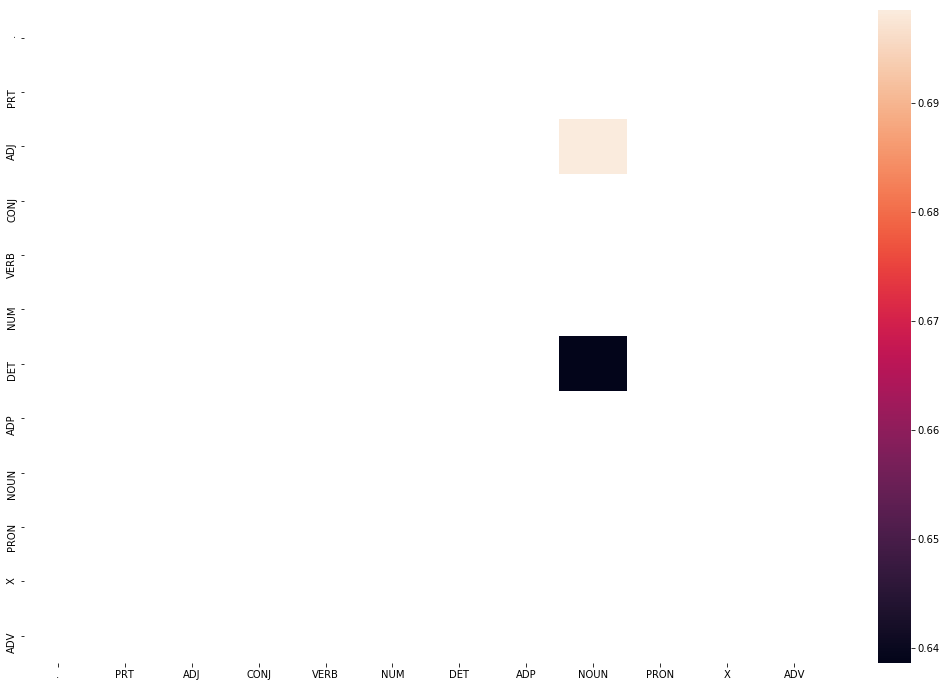

In [26]:
# frequent tags
# 7. filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

###### Visualize transition matrix as a heat map to see how each of these probabilities look like. It shows noun following adjective has one of the highest probability

In [27]:
len(train_tagged_words)

95799

In [28]:
# 8. Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            count_w_given_tag, count_tag = word_given_tag(words[key], tag)
            emission_p = count_w_given_tag/count_tag
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [29]:
# 9. validation untagged words
validation_untagged_words = [tup[0] for sent in nltk_data_vali_set for tup in sent]

In [30]:
len(validation_untagged_words)

4877

In [31]:
# 9. tagging the validation sentences
start = time.time()
tagged_seq = Viterbi(validation_untagged_words)
end = time.time()
difference = end-start

In [32]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  471.90437293052673
[('Ruth', '.'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', '.'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', '.'), ('trade', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', '.'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', '.'), ('with', 'ADP'), ('Buick', 'NOUN'), ('ca

In [33]:
# accuracy on validation dataset
check = [i for i, j in zip(tagged_seq, validation_tagged_words) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.9071150297313922

In [34]:
incorrect_tagged_cases = [[validation_tagged_words[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_tagged_words)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Ruth', '.'), ('Ruth', 'NOUN'))],
 [('Nelson', 'NOUN'), (('Cullowhee', '.'), ('Cullowhee', 'NOUN'))],
 [('shares', 'NOUN'), (('*T*-121', '.'), ('*T*-121', 'X'))],
 [('*T*-121', 'X'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('.', '.'), (('Card', '.'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', '.'), ('sweepstakes', 'NOUN'))],
 [('Maxwell', 'NOUN'), (('R.D.', '.'), ('R.D.', 'NOUN'))],
 [('R.D.', 'NOUN'), (('Vos', '.'), ('Vos', 'NOUN'))],
 [(',', '.'), (('N.Y', '.'), ('N.Y', 'NOUN'))],
 [('The', 'DET'), (('Perch', '.'), ('Perch', 'NOUN'))],
 [('and', 'CONJ'), (('Dolphin', '.'), ('Dolphin', 'NOUN'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('the', 'DET'), (('Seahorse', '.'), ('Seahorse', 'NOUN'))],
 [('and', 'CONJ'), (('Tarwhine', '.'), ('Tarwhine', 'NOUN'))],
 [('be', 'VERB'), (('refunded', '.'), ('refunded', 'VERB'))],
 [('newly', 'ADV'), (('fattened', '.'), ('fattened', 'VERB'))],
 [('a', 'DET'), (('disembodied', '.'), ('disembodie

In [35]:
len(incorrect_tagged_cases)

453

### Read test_sentences file and understand the word patterns in it

In [36]:
# Let's read the test sentences sample file given to see and understand the pattern of words and tag sequence 
testfile = pd.read_csv("Test_sentences.txt", sep = '\t')
testfile

,Android is a mobile operating system developed by Google.
0,Android has been the best-selling OS worldwide...
1,Google and Twitter made a deal in 2015 that ga...
2,Twitter is an online news and social networkin...
3,"Before entering politics, Donald Trump was a d..."
4,The 2018 FIFA World Cup is the 21st FIFA World...
5,This is the first World Cup to be held in East...
6,Show me the cheapest round trips from Dallas t...
7,I would like to see flights from Denver to Phi...
8,Show me the price of the flights leaving Atlan...
9,NASA invited social media users to experience ...


In [37]:
listOfSent = testfile.values.tolist()
listOfSent

[['Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'],
 ["Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."],
 ['Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'],
 ['Before entering politics, Donald Trump was a domineering businessman and a television personality.'],
 ['The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'],
 ['This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'],
 ['Show me the cheapest round trips from Dallas to Atlanta'],
 ['I would like to see flights from Denver to Philadelphia.'],
 ['Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'],
 ['NASA invited social media users to experience the launch of ICESAT-2 Satellite.']]

In [38]:
listaOfWordsInSent = []
import re
for j in listOfSent:
    str1 = ''.join(j)
    str1 = re.sub(r'[.]',' .',str1)
    str1 = re.sub(r'[,]',' ,',str1)
    a = str1.split(" ")
    listaOfWordsInSent.append(a)
print(listaOfWordsInSent)


[['Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.'], ['Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', "Twitter's", 'firehose', '.'], ['Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.'], ['Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.'], ['The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.'], ['This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and', 'the', '11th', 'time', 'that', 'it', 'has', 'been', 'held', 'in', 'Europe', '.'],

In [39]:
listOfWords = [word for sent in listaOfWordsInSent for word in sent]
listOfWords

['Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 "Twitter's",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.',
 'This',
 'is',
 'the',
 'first',
 'World',
 'Cup',
 'to',
 'be',
 'held',
 'in',
 'Eastern',
 'Europe

In [40]:
words_train_set[0:5]

['This', 'year', ',', 'the', 'average']

In [41]:
# words which are present in test_sentences file but are not present in train set
# unknown_words_in_file = np.setdiff1d(listOfWords,words_train_set) - this gives a set of unique words
unknown_words_in_file = [word for word in listOfWords if word not in words_train_set]
print(len(unknown_words_in_file))

34


In [42]:
unknown_words_in_file

['Android',
 'OS',
 'worldwide',
 'smartphones',
 '2011',
 '2013',
 'Google',
 'Twitter',
 '2015',
 'Google',
 "Twitter's",
 'firehose',
 'Twitter',
 'online',
 'interact',
 'messages',
 'tweets',
 'domineering',
 'personality',
 '2018',
 'FIFA',
 'Cup',
 '21st',
 'FIFA',
 'Cup',
 'tournament',
 'contested',
 'Cup',
 'trips',
 'arriving',
 'NASA',
 'invited',
 'ICESAT-2',
 'Satellite']

In [43]:
# Let's see what tag should be assigned to these words
# List of tags available
#'.', 'ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRON','PRT','VERB','X'

# Real tags on words in test_sentences file
# Android - Noun, 2011 - number, 2013 - number, 2015 - number, 2018 - number, 21st - number, Cup - noun, FIFA - noun, 
# Google - noun, ICESAT-2 - noun, NASA - noun, OS - noun, Satellite- noun, Twitter - noun, Twitters - noun, arriving - verb,
# best-selling - adjective, contested - verb, domineering - adjective, firehose - noun, interact - verb, invented - verb,
# messages - noun, online - adjective, personality - noun, smartphones - noun, tournament - noun, trips - noun, tweets - noun
# worldwide - noun etc..

# Let's form some rule (regular expression that takes care of the correct tags for these words)


### Solve the problem of unknown words

#### Approach 1

In [44]:
# 1. make rules from words in test_sentence file
# Steps:
#Step 1: if the word has all numeric values 
#       then it is a number
#Step 2: else if the word ends with ing or ed 
#        then it is a verb 
# but there are multiple words like best-selling which have hyphen in between and 
# end with ed or ing and are not verb but adjective so, change step 2 
# Real Step 2: else if word ends with inf or ed and has one hyphen (-) 
#       then it is an adjective
# Step 3: previous step 2 becomes step 3
# Step 4: else if words that start with capital letter
#       then it is a noun
# Also in rest of the case most of the words are noun. Therefore, for this case step 4 is not as such required


In [45]:
# 2. Modified Viterbi Heuristic
def Viterbi_modified_1(words, train_bag = train_tagged_words):
    train_words = [pair[0] for pair in train_bag]
    unknown_W = [x for x in words if x not in train_words]
    known_W =   [x for x in words  if x not in unknown_W]
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        if word in known_W:
        #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                count_w_given_tag, count_tag = word_given_tag(words[key], tag)
                emission_p = count_w_given_tag/count_tag
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        elif word in unknown_W:
            if re.search(r'^[0-9]+$',word):
                state.append('NUM')
            elif (word.endswith('ing') or word.endswith('ed')) and (re.search(r'[-]+',word)):
                state.append('ADJ')
            elif word.endswith('ing') or word.endswith('ed'):
                state.append('VERB')
            elif re.search(r'^[A-Z]+\w',word):
                state.append('NOUN')
            else:
                state.append('NOUN')
    return list(zip(words, state))

In [46]:
print(len(validation_untagged_words))

4877


In [47]:
# tagging the validation sentences
start = time.time()
tagged_seq = Viterbi_modified_1(validation_untagged_words)
end = time.time()
difference = end-start

In [48]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  435.7170526981354
[('Ruth', 'NOUN'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'NOUN'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'NOUN'), ('trade', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'NOUN'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'NOUN'), ('with', 'ADP'), ('Buick',

#### Evaluating tagging accuracy

In [49]:
# accuracy
check = [i for i, j in zip(tagged_seq, validation_tagged_words) if i == j] 

In [50]:
accuracy = len(check)/len(tagged_seq)

In [51]:
accuracy

0.9479188025425467

In [52]:
incorrect_tagged_cases = [[validation_tagged_words[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_tagged_words)) if j[0]!=j[1]]

In [53]:
incorrect_tagged_cases

[[('shares', 'NOUN'), (('*T*-121', 'NOUN'), ('*T*-121', 'X'))],
 [('*T*-121', 'X'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('a', 'DET'), (('disembodied', 'VERB'), ('disembodied', 'ADJ'))],
 [('disembodied', 'ADJ'), (('male', 'ADJ'), ('male', 'NOUN'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NOUN'), ('300-day', 'ADJ'))],
 [('remains', 'VERB'), (('male-only', 'NOUN'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-230', 'NOUN'), ('*T*-230', 'X'))],
 [('*T*-230', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('particularly', 'ADV'), (('galling', 'VERB'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole', 'ADJ'))],
 [('funds', 'NOUN'), (('mirrors', 'NOUN'), ('mirrors', 'VERB'))],
 [('the', 'DET'), (('1920s', 'NUM'), ('1920s', 'NOUN'))],
 [('when', 'ADV'), (('narrowly', 'NOUN'), ('narrowly', 'ADV')

In [54]:
print(len(incorrect_tagged_cases))

254


#### Approach 2

In [55]:
#Note: 
#Viterbi algorithm uses emission probability which is probability that an observation is 
#emitted by a particular state. Here state is tag. For unknown words, emission probability is zero.
# Which results in choosing arbitrarily first tag for unknown words. So, if only transmission probability is
# considered for unknown words then it will more accurately tag unknown words

In [56]:
# 1. Viterbi Heuristic
def Viterbi_modified_2(words, train_bag = train_tagged_words):
    train_words = [pair[0] for pair in train_bag]
    unknown_W = [x for x in words if x not in train_words]
    known_W =   [x for x in words  if x not in unknown_W]
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words): 
            #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in known_W:
                count_w_given_tag, count_tag = word_given_tag(words[key], tag)
                emission_p = count_w_given_tag/count_tag
                state_probability = emission_p * transition_p  
            elif word in unknown_W:
                state_probability = transition_p
            p.append(state_probability)
        
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        
    return list(zip(words, state))

In [57]:
# tagging the validation sentences
start = time.time()
tagged_seq = Viterbi_modified_2(validation_untagged_words)
end = time.time()
difference = end-start

In [58]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  431.0918960571289
[('Ruth', 'NOUN'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'NOUN'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'NOUN'), ('trade', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'NOUN'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'NOUN'), ('with', 'ADP'), ('Buick',

In [59]:
# accuracy
check = [i for i, j in zip(tagged_seq, validation_tagged_words) if i == j] 

In [60]:
accuracy = len(check)/len(tagged_seq)

In [61]:
accuracy

0.9360262456428132

In [62]:
incorrect_tagged_cases = [[validation_tagged_words[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_tagged_words)) if j[0]!=j[1]]

In [63]:
incorrect_tagged_cases

[[('shares', 'NOUN'), (('*T*-121', 'NOUN'), ('*T*-121', 'X'))],
 [('*T*-121', 'X'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('be', 'VERB'), (('refunded', 'X'), ('refunded', 'VERB'))],
 [('a', 'DET'), (('disembodied', 'NOUN'), ('disembodied', 'ADJ'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NOUN'), ('300-day', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'NOUN'), ('bell-ringing', 'ADJ'))],
 [('in', 'ADP'), (('1637', 'DET'), ('1637', 'NUM'))],
 [('remains', 'VERB'), (('male-only', 'X'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-230', 'DET'), ('*T*-230', 'X'))],
 [('particularly', 'ADV'), (('galling', 'VERB'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole', 'ADJ'))],
 [("'s", 'PRT'), (('Cathedral', 'VERB'), ('Cathedral', 'NOUN'))],
 [("'s", 'PRT'), (('short-lived', 'VERB'), ('short

In [64]:
print(len(incorrect_tagged_cases))

312


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [65]:
# POS -Tagging
# Approach            Accuracy(%)   Wrong_tagged_words    Comments
#------------------------------------------------------------------
# Vanila Viterbi      90.7          453                   This approach uses basic viterbi heuristic
# ------------------------------------------------------------------------------------------------
# Approach 1          94.8          254                   This approach uses the viterbi approach 
#                                                         for known words and rule based approach 
#                                                         for unknown words
# ------------------------------------------------------------------------------------------------
# Approach 2          93.6          312                   This approach uses vanilla viterbi approach
#                                                         for known words and uses on transition probability
#                                                         for calculating state probability of unknown words
# ------------------------------------------------------------------------------------------------

# Approach 1 improves the accuracy by 4.1%
# Approach 2 improves the accuracy by 2.9% 
                                                                


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [66]:
# Correct tagged list of words in test_sequences file
# Android - Noun, 2011 - number, 2013 - number, 2015 - number, 2018 - number, 21st - number, Cup - noun, FIFA - noun, 
# Google - noun, ICESAT-2 - noun, NASA - noun, OS - noun, Satellite- noun, Twitter - noun, Twitters - noun, arriving - verb,
# best-selling - adjective, contested - verb, domineering - adjective, firehose - noun, interact - verb, invented - verb,
# messages - noun, online - adjective, personality - noun, smartphones - noun, tournament - noun, trips - noun, tweets - noun
# worldwide - noun, etc...

In [67]:
# Vanilla Viterbi
tagged_seq = Viterbi(unknown_words_in_file)
print(tagged_seq)

[('Android', '.'), ('OS', '.'), ('worldwide', '.'), ('smartphones', '.'), ('2011', '.'), ('2013', '.'), ('Google', '.'), ('Twitter', '.'), ('2015', '.'), ('Google', '.'), ("Twitter's", '.'), ('firehose', '.'), ('Twitter', '.'), ('online', '.'), ('interact', '.'), ('messages', '.'), ('tweets', '.'), ('domineering', '.'), ('personality', '.'), ('2018', '.'), ('FIFA', '.'), ('Cup', '.'), ('21st', '.'), ('FIFA', '.'), ('Cup', '.'), ('tournament', '.'), ('contested', '.'), ('Cup', '.'), ('trips', '.'), ('arriving', '.'), ('NASA', '.'), ('invited', '.'), ('ICESAT-2', '.'), ('Satellite', '.')]


In [68]:
# Vanilla viterbi tags each unknown word as a . (as emission probability is 
# 0 hence, assigns arbitrarily a tag which is '.')

In [69]:
# Approach 1 to modify viterbi
tagged_seq = Viterbi_modified_1(unknown_words_in_file)
print(tagged_seq)

[('Android', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('smartphones', 'NOUN'), ('2011', 'NUM'), ('2013', 'NUM'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('2015', 'NUM'), ('Google', 'NOUN'), ("Twitter's", 'NOUN'), ('firehose', 'NOUN'), ('Twitter', 'NOUN'), ('online', 'NOUN'), ('interact', 'NOUN'), ('messages', 'NOUN'), ('tweets', 'NOUN'), ('domineering', 'VERB'), ('personality', 'NOUN'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('Cup', 'NOUN'), ('trips', 'NOUN'), ('arriving', 'VERB'), ('NASA', 'NOUN'), ('invited', 'VERB'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [70]:
# Cases that were incorrectly tagged by original POS tagger and got corrected by modifications
# word          tag_by_original    tag_after_modification
# -------------------------------------------------------
# 2011          .                  NUM
# 2013          .                  NUM
# -------------------------------------------------------
# Cup           .                  NOUN
# Android       .                  NOUN
# Satellite     .                  NOUN
# -------------------------------------------------------
# Contested     .                  VERB
# Invited       .                  VERB


In [71]:
# Approach 2 to modify Vanilla viterbi
tagged_seq = Viterbi_modified_2(unknown_words_in_file)
print(tagged_seq)

[('Android', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('smartphones', 'NOUN'), ('2011', 'NOUN'), ('2013', 'NOUN'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('2015', 'NOUN'), ('Google', 'NOUN'), ("Twitter's", 'NOUN'), ('firehose', 'NOUN'), ('Twitter', 'NOUN'), ('online', 'NOUN'), ('interact', 'NOUN'), ('messages', 'NOUN'), ('tweets', 'NOUN'), ('domineering', 'NOUN'), ('personality', 'NOUN'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('Cup', 'NOUN'), ('trips', 'NOUN'), ('arriving', 'NOUN'), ('NASA', 'NOUN'), ('invited', 'NOUN'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [72]:
# Cases that were incorrectly tagged by original POS tagger and got corrected by modifications
# word          tag_by_original    tag_after_modification
# OS            .                  NOUN
# tweets        .                  NOUN
# Google        .                  NOUN

In [ ]:
# Hence, we saw unknown words are assigned a random tag arbitrarily with vanilla viterbi and when we modify
# and use a different approach for unknown words like finding the patterns in words or by checking the 
# previous tag of word or by not using emission probablility for unknown words, the accuracy improves
# because for known words it is viterbi and for unknown it is now better that random.